<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%5B6%5D%EA%B3%A0%EA%B0%9D%EB%93%B1%EA%B8%89%EC%98%88%EC%B8%A1_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이번엔 구글의 tensorflow 대신 페이스북이 개발한 pytorch 모듈을 사용해보겠습니다.  

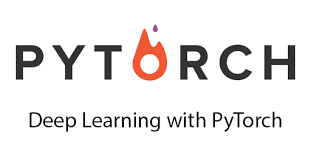

# 고객의 이미지로 등급을 예측하여 보자

In [1]:
## 필요한 라이브러리 불러오기
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split;  from matplotlib import style
from torch.autograd import Variable
from __future__ import print_function; from torch import nn, optim, cuda, tensor
from torch.utils import data; from torchvision import datasets, transforms
import torch.nn.functional as F ; import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch; from torch.autograd import Variable

!git clone https://github.com/hongjai-rhee/public.git

Cloning into 'public'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 520 (delta 74), reused 69 (delta 22), pack-reused 353
Receiving objects: 100% (520/520), 54.04 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (252/252), done.


# 숫자는 이미지로 이미지는 숫자로 변화될 수 있다. 
**국민배우, 마동석의 사진을 불러와서, 숫자벡터로 바꾸어보자.**
.

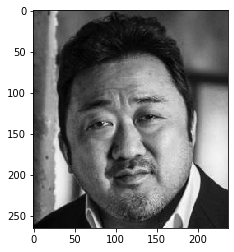

In [2]:
import cv2; from google.colab.patches import cv2_imshow
df='/content/public/image1.JPG'  
x1=cv2.imread(df); 
x1= cv2.cvtColor(x1, cv2.COLOR_BGR2GRAY)  ## 흑백으로 변환
plt.imshow(x1,  cmap='gray')
plt.show()

In [3]:
print(x1)
x1.shape


[[81 78 75 ... 64 64 64]
 [83 82 82 ... 64 64 65]
 [78 80 82 ... 65 65 65]
 ...
 [ 6  7  9 ... 27 27 27]
 [ 8  8  7 ... 26 26 25]
 [ 5  6  6 ... 26 25 25]]


(265, 237)

이 사진은 265*237 픽셀을 가지고, 숫자는 각 픽셀의 RGB 코드를 의미한다. 


# ‘customer1500.csv’ 파일을 구글 드라이브에 마운트 한 다음 데이터 파일을 불러오자




In [4]:
dat = np.array(pd.read_csv('/content/public/customer1500.csv'))

y=dat[:,0]; x=dat[:,1:65] #  y=3개의 고객상태 label(0/1/2), x=64개의 특성벡터
class_names = ['buy NONE', 'buy SMALL', 'buy BIG']   

## 훈련과 검증셋으로 나누기
x_train=x[0:1000,]; x_test=x[1000:1499,]
y_train=y[0:1000,]; y_test=y[1000:1499,]
 

# 토치 모맷으로 데이터 바꾸기
x_train = Variable(torch.Tensor(x_train).float())
x_test = Variable(torch.Tensor(x_test).float())
y_train = Variable(torch.Tensor(y_train).long())   ## long =정수
y_test = Variable(torch.Tensor(y_test).long())

## 훈련과 검증셋으로 나누기
x_train=x[0:1000,]; x_test=x[1000:1499,]
y_train=y[0:1000,]; y_test=y[1000:1499,]

# 토치 포맷으로 데이터 바꾸기
x_train = Variable(torch.Tensor(x_train).float())
x_test = Variable(torch.Tensor(x_test).float())
y_train = Variable(torch.Tensor(y_train).long())   ## long =정수
y_test = Variable(torch.Tensor(y_test).long())

print(x_train.shape, y_train.shape)

torch.Size([1000, 64]) torch.Size([1000])


# x는 고객의 특성(프로파일)을 64개의 숫자벡터로 표현한 것이다.
# 특성은 인구통계학적 특성, 구매이력, 또는 사진 등이 될 수 있다

In [5]:
print(x[1])  ## 1번 고객의 특성 벡터

[0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1]


# y는 각 고객이 어떤 등급에 속하는지 나타내는 레이블이다. 
 
 	0= buy none
 	1= buy small
 	2= buy big

In [6]:
print(y[0:100])

[0 2 0 1 0 2 1 0 2 1 2 2 2 0 2 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 1 1 2 0 2 1 1
 1 0 2 1 1 1 1 1 2 0 1 2 2 0 2 1 2 1 1 1 0 2 0 0 1 1 1 0 2 1 2 2 2 1 1 2 0
 1 1 1 1 1 0 2 1 1 1 1 1 2 1 2 1 2 1 1 0 1 1 0 2 1 1]


# 고객의 특성을 시각화하여 보자. 
얼굴이미지도 동일하게 처리 가능하다. 어떻게 생긴 고객이 우리 제품 구매가능성이 더 높을까? ㅎㅎ  


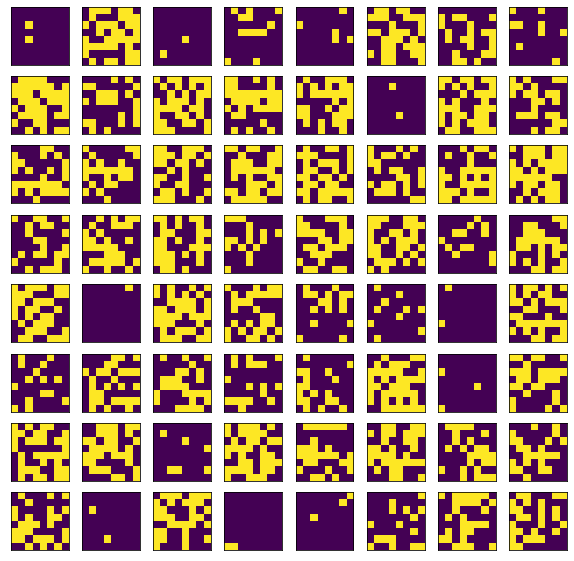

In [7]:
# 이미지 벡터 시각화
z = x.reshape(1499, 8,8)
plt.figure(figsize=(10,10))
for i in range(64) :
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(z[i])
plt.show()

# 모형 설정 (using Pytorch developed by Facebook)

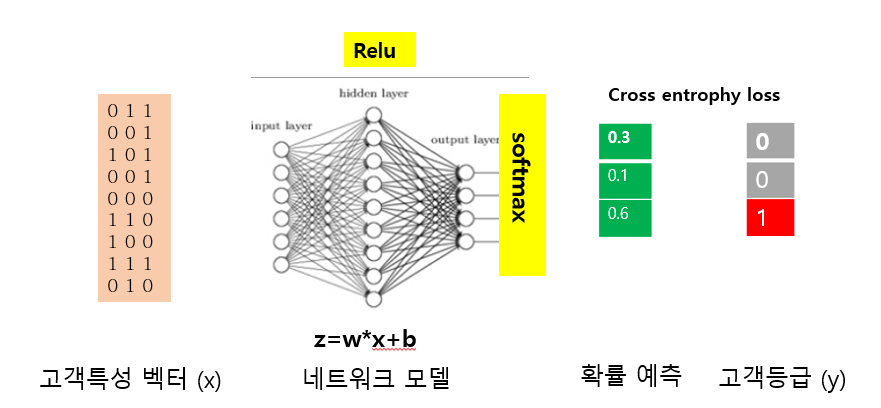

In [0]:
nb_epochs = 5000   # 학습횟수, 미니배치=NO
hidden=0           # hidden layer neoron의 수, 단층망 if 0
learn_rate=0.01


이 아래는 자동으로 실행됨 (do not touch !)

In [9]:
## 아래는 자동
n_input= x_train.shape[1]
n_output=torch.max(y_train.data).item()+1
print(n_input, hidden, n_output)

class Net(nn.Module):

    def __init__(self):    ## 레이어 구조 설정 (자동)
        super(Net, self).__init__()
        if hidden==0 :
          self.l0 = nn.Linear(n_input, n_output)    ## 아웃풋레이어
        else:
          self.l1 = nn.Linear(n_input, hidden)   
          self.l2 = nn.Linear(hidden, n_output)    
          #self.l3 = nn.Linear(10, 6)              
          #self.l4 = nn.Linear(6, 4)    ## 다양한 층으로 구성가능하다  
        
    def forward(self, x):  ## 연산방법과 활성화함수 설정
        if hidden==0 : 
          return self.l0(x)           
        else:  
          x = F.relu(self.l1(x))
          return self.l2(x)           

model = Net()
criterion = nn.CrossEntropyLoss()    ## 손실함수 지정
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.5)   ## 최적화모듈 지정


64 0 3


# 학습 실행

In [10]:

for epoch in range(nb_epochs+1 ):
    hypothesis = model(x_train)            # f(x) 계산
    loss = criterion(hypothesis, y_train)  # loss 계산
    loss.backward()                        # 백프로파게이션 for gradient
    optimizer.step()                       # 파라미터 업데이트 
  
    if epoch % 100 == 0:
        print('number of epoch=','[%d] loss: %.3f' %
                  ( epoch ,loss.data))
  
## 츨력사항 지정
predict_out = model(x_test)
_, predict_y = torch.max(predict_out, 1)
print('===================>>>>>>')
print('test-set prediction accuracy = ', np.round(100*accuracy_score(y_test.data, predict_y.data),2), "%")

number of epoch= [0] loss: 1.279
number of epoch= [100] loss: 0.715
number of epoch= [200] loss: 5.093
number of epoch= [300] loss: 0.953
number of epoch= [400] loss: 2.914
number of epoch= [500] loss: 3.685
number of epoch= [600] loss: 11.014
number of epoch= [700] loss: 4.080
number of epoch= [800] loss: 2.489
number of epoch= [900] loss: 2.378
number of epoch= [1000] loss: 0.802
number of epoch= [1100] loss: 1.326
number of epoch= [1200] loss: 2.536
number of epoch= [1300] loss: 5.062
number of epoch= [1400] loss: 15.271
number of epoch= [1500] loss: 6.668
number of epoch= [1600] loss: 0.878
number of epoch= [1700] loss: 10.443
number of epoch= [1800] loss: 12.169
number of epoch= [1900] loss: 1.090
number of epoch= [2000] loss: 13.066
number of epoch= [2100] loss: 5.303
number of epoch= [2200] loss: 3.460
number of epoch= [2300] loss: 12.706
number of epoch= [2400] loss: 1.604
number of epoch= [2500] loss: 14.839
number of epoch= [2600] loss: 0.488
number of epoch= [2700] loss: 14.

# 예측결과 평가하기

Confusion Matrix; 대각선은 올바른 예측


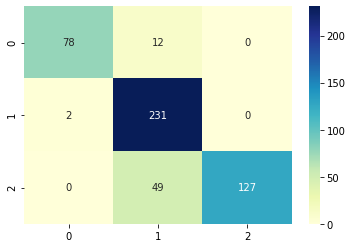

In [14]:
from sklearn.metrics import confusion_matrix, classification_report; import seaborn as sn
yhat=torch.argmax(model(x_test),axis=1)
import pandas as pd
import seaborn as sn
print('Confusion Matrix; 대각선은 올바른 예측')
cm=confusion_matrix(y_test, yhat)
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")


# 학습된 모형을 이용하여, 신규고객의 특성을 보고 고객유형을 예측을 해보자.

In [18]:
# 예측하기 
from random import randint

i = randint(1, 100)  # 1부터 100 사이의 임의의 정수

x_new= x_test[i]
print(i, '번 고객의 특성 벡터')
print('=======================')
print(x_new.numpy())
yhat =model(x_new) ; yhat =F.softmax(model(x_new), dim=0); yy=torch.argmax(yhat)

class color:
   PURPLE = '\033[95m'; BLUE = '\033[94m' ;  RED = '\033[91m' ; BOLD = '\033[1m';  UNDERLINE = '\033[4m' ; END = '\033[0m'

print()
print('========>  이 고객은', 100*yhat[yy].data.item(), '%의 확률로', color.RED  + class_names[yy] + color.END, "유형으로 예측됩니다")
#EOF

85 번 고객의 특성 벡터
[0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]

========>  이 고객은 100.0 %의 확률로 buy SMALL 유형으로 예측됩니다


# 신종 코로나 발생확률을 예측하려면 어떤 데이터가 필요할까요?

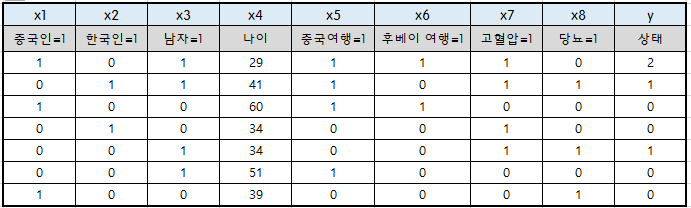